In [ ]:
pip install imblearn

In [3]:
pip install -U scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/08/5d/e5acecd6e99a6b656e42e7a7b18284e2f9c9f512e8ed6979e1e75d25f05f/scikit_learn-1.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 709.7 kB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.1
    Uninstalling scikit-learn-1.3.1:
      Successfully uninstalled scikit-learn-1.3.1

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import re
import os
import math
import pickle
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from scipy.sparse import hstack, vstack
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, confusion_matrix, f1_score, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

----

In [16]:
# Import the final dataset generated after all the Data Preprocessing.
data = pd.read_csv('Data/finalData.csv')

In [17]:
# Split the Dataset into set of features and Class Label
dataY = data['PotentialFraud'] # Class Label
dataX = data.drop(columns='PotentialFraud') # Features

In [18]:
# Split the dataset into Train and Test in the ratio of 80:20
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size=0.2, stratify=dataY)

In [19]:
print('Shape of the Train Dataset (Features): ', xTrain.shape)
print('Shape of the Train Dataset (Class Label)', yTrain.shape)
print('Shape of the Test Dataset (Features): ', xTest.shape)
print('Shape of the Test Dataset (Class Label)', yTest.shape)

Shape of the Train Dataset (Features):  (446568, 48)
Shape of the Train Dataset (Class Label) (446568,)
Shape of the Test Dataset (Features):  (111643, 48)
Shape of the Test Dataset (Class Label) (111643,)


----

In [20]:
%%time
# Create an object of 'RandomUnderSampler'
rndmUndrSampler = RandomUnderSampler(sampling_strategy=1)

# Create Random Undersampled Dataset by calling the 'fit_resample' method
xTrainRndmUS, yTrainRndmUS = rndmUndrSampler.fit_resample(xTrain, yTrain)

CPU times: user 358 ms, sys: 182 ms, total: 539 ms
Wall time: 641 ms


In [21]:
print('Shape of the Train Dataset (Features) after Random Undersampling: ', xTrainRndmUS.shape)
print('Shape of the Train Dataset (Class Label) Random Undersampling', yTrainRndmUS.shape)

Shape of the Train Dataset (Features) after Random Undersampling:  (340472, 48)
Shape of the Train Dataset (Class Label) Random Undersampling (340472,)


In [22]:
print('After Random Undersampling, count of unique labels:')
yTrainRndmUS.value_counts()

After Random Undersampling, count of unique labels:


PotentialFraud
0    170236
1    170236
Name: count, dtype: int64

In [23]:
%%time
if os.path.isfile('Data/xTrainSMOTE.csv') and os.path.isfile('Data/yTrainSMOTE.csv'):

    xTrainSMOTE = pd.read_csv('Data/xTrainSMOTE.csv')
    yTrainSMOTE = pd.read_csv('Data/yTrainSMOTE.csv')

else:

    # Create an SMOTE object
    smote = SMOTE(sampling_strategy=1)
    
    # Create Oversampled Dataset by calling the 'fit_resample' method
    xTrainSMOTE, yTrainSMOTE = smote.fit_resample(xTrain, yTrain)

    ## Save the Dataset
    xTrainSMOTE.to_csv('Data/xTrainSMOTE.csv', index=False)
    yTrainSMOTE.to_csv('Data/yTrainSMOTE.csv', index=False)

CPU times: user 4min 1s, sys: 2.12 s, total: 4min 3s
Wall time: 1min 9s


In [24]:
print('Shape of the Train Dataset (Features) after SMOTE Oversampling: ', xTrainSMOTE.shape)
print('Shape of the Train Dataset (Class Label) SMOTE Oversampling', yTrainSMOTE.shape)

Shape of the Train Dataset (Features) after SMOTE Oversampling:  (552664, 48)
Shape of the Train Dataset (Class Label) SMOTE Oversampling (552664,)


In [26]:
yTrainSMOTE = yTrainSMOTE.squeeze() # Convert the DataFrame to Series for Class Label

In [27]:
print('After SMOTE Oversampling, count of unique labels:')
yTrainSMOTE.value_counts()

After SMOTE Oversampling, count of unique labels:


PotentialFraud
0    276332
1    276332
Name: count, dtype: int64

----

In [31]:
print('Shape of the Train Data before doing response encoding of \'State\' and \'Country\' Features:',  xTrain.shape)
print('Shape of the Test Data before doing response encoding of \'State\' and \'Country\' Features:',  xTest.shape)
print('Shape of the Train Data after doing response encoding of \'State\' and \'Country\' Features:',  xTrainRE.shape)
print('Shape of the Test Data after doing response encoding of \'State\' and \'Country\' Features:',  xTestRE.shape)

Shape of the Train Data before doing response encoding of 'State' and 'Country' Features: (446568, 48)
Shape of the Test Data before doing response encoding of 'State' and 'Country' Features: (111643, 48)
Shape of the Train Data after doing response encoding of 'State' and 'Country' Features: (446568, 50)
Shape of the Test Data after doing response encoding of 'State' and 'Country' Features: (111643, 50)


* We can see that 2 extra features are available after doing response encoding and not 4. This is because the original State and Country features were removed and 4 new features were added. Hence, the total change is 4 - 2 = 2.

In [32]:
# Display top 5 records from the response encoded Train Dataset
xTrainRE.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0,State_0,State_1,Country_0,Country_1
0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,81,0,0.0,6268,2210,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.702086,0.297914,0.745150,0.254850
1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,0,100.0,3068,7870,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.774983,0.225017,0.598892,0.401108
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,88,0,30.0,0,1840,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.538002,0.461998,0.639752,0.360248
3,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,61,0,0.0,0,2570,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.702086,0.297914,0.781065,0.218935
4,0,1,0,0,0,0,0,2,0,1,0,0,0,0,1,1,0,0,0,0,0,0,65,0,50.0,0,2280,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.702086,0.297914,0.589579,0.410421


In [36]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    '''
    Class to do One-hot Encoding for the Categorical features.
    This class can be used in the sklearn's Pipeline to avoid data leakage issues
    '''
    def __init__(self, categoricalFeatures):
        '''
        Function to initialize the class members
        
        Parameter(s):
        ------------
        categoricalFeatures: list
            List of features for which the response encoding has to be done to generate new one-hot encoded features.
        '''
        self.categoricalFeatures = categoricalFeatures # Categorical Features for which One-hot Encoding has to be done.
        self.countVectorizers = dict() # Dictionary of CountVectorizer object for each features to be one-hot encoded.
        
        # Add CountVectorizer object for each feature to the dictionary 'self.countVectorizers'
        for feature in categoricalFeatures:
            
            # 'CountVectorizer not considering single letter text': https://stackoverflow.com/a/63339533/16007029
            self.countVectorizers[feature] = CountVectorizer(tokenizer=lambda x: x.split())
        
    def fit(self, X, y=None):        
        '''
        Function called on a Dataset (usually Train Dataset) to generate One-hot Encoded Features.
        This function is called only for the train dataset and not for any cv/test dataset to avoid data leakage.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the Response Encoding has to be carried out.
        '''
        
        # Fit the CountVectorizer object for each feature, on the Train Data feature
        for feature in self.categoricalFeatures:
            
            self.countVectorizers[feature].fit(pd.Series(X[feature]).astype(str).values)
            
        return self
    
    def transform(self, X, y=None):
        '''
        Function called on a Dataset (Train/Test Dataset) and/or Class Label to generate One-hot Encoded Features.
        This is called to avoid any data leakage. This uses the CountVectorizer object already prepared by the fit() method
        and does not consider the test dataset.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            DataFrame on which the One-hot Encoding has to be done.
        '''
        
        # Create a copy of the dataframe so that it does not modify the input dataframe
        xEncoded = X.copy()
        
        oneHotEncodedFeatures = dict() # Dictionary to store the feature name as key and its one-hot encoded csr matrix in its value
        
        # Transform each of the categorical feature to convert to one-hot encoding
        for feature in self.categoricalFeatures:
            
            oneHotEncodedFeatures[feature] = self.countVectorizers[feature].transform(pd.Series(xEncoded[feature]).astype(str).values)
            
        # Remove the original categorical features from the Dataset
        xEncoded.drop(columns=self.categoricalFeatures, inplace=True)
        
        # Stack (horizontally) the new one-hot encoded features to the dataset
        for feature in self.categoricalFeatures:
            
            xEncoded = hstack((xEncoded, oneHotEncodedFeatures[feature])).tocsr()
            
        # Return this DataFrame with all the numerical features and the one-hot encoded features for the categorical features
        return xEncoded

In [37]:
%%time
# Create an object of the 'OneHotEncoder' class
onehotEnc = OneHotEncoder(categoricalFeatures=['State', 'Country'])

# Fit the 'OneHotEncoder' class object on only Train Data
onehotEnc.fit(xTrain, yTrain)

CPU times: user 2.91 s, sys: 138 ms, total: 3.05 s
Wall time: 3.47 s


OneHotEncoder(categoricalFeatures=['State', 'Country'])

In [38]:
%%time
# Transform the 'OneHotEncoder' class object to get the one-hot encoded features for the categorical features:
# 'State' and 'Country'
xTrainOHE = onehotEnc.transform(xTrain) # Train Data

xTestOHE = onehotEnc.transform(xTest) # Test Data

CPU times: user 6.02 s, sys: 1.55 s, total: 7.57 s
Wall time: 8.5 s


In [39]:
print('Shape of the Train Data before doing one-hot encoding of \'State\' and \'Country\' Features:',  xTrain.shape)
print('Shape of the Test Data before doing one-hot encoding of \'State\' and \'Country\' Features:',  xTest.shape)
print('Shape of the Train Data after doing one-hot encoding of \'State\' and \'Country\' Features:',  xTrainOHE.shape)
print('Shape of the Test Data after doing one-hot encoding of \'State\' and \'Country\' Features:',  xTestOHE.shape)

Shape of the Train Data before doing one-hot encoding of 'State' and 'Country' Features: (446568, 48)
Shape of the Test Data before doing one-hot encoding of 'State' and 'Country' Features: (111643, 48)
Shape of the Train Data after doing one-hot encoding of 'State' and 'Country' Features: (446568, 409)
Shape of the Test Data after doing one-hot encoding of 'State' and 'Country' Features: (111643, 409)


In [40]:
print('Number of unique states in the Train Dataset: ', len(xTrain['State'].unique()))
print('Number of unique countried in the Train Dataset: ', len(xTrain['Country'].unique()))

Number of unique states in the Train Dataset:  52
Number of unique countried in the Train Dataset:  311


In [41]:
print('Final Dataset 1 (with Response Encoded State and Country Features):')
print('--'*40)
print('Train Dataset: Features-', xTrainRE.shape, ', Class Labels: ', yTrain.shape)
print('Test Dataset: Features-', xTestRE.shape, ', Class Labels: ', yTest.shape)

print('=='*40)

print('Final Dataset 2 (with One-hot Encoded State and Country Features):')
print('--'*40)
print('Train Dataset: Features-', xTrainOHE.shape, ', Class Labels: ', yTrain.shape)
print('Test Dataset: Features-', xTestOHE.shape, ', Class Labels: ', yTest.shape)

Final Dataset 1 (with Response Encoded State and Country Features):
--------------------------------------------------------------------------------
Train Dataset: Features- (446568, 50) , Class Labels:  (446568,)
Test Dataset: Features- (111643, 50) , Class Labels:  (111643,)
Final Dataset 2 (with One-hot Encoded State and Country Features):
--------------------------------------------------------------------------------
Train Dataset: Features- (446568, 409) , Class Labels:  (446568,)
Test Dataset: Features- (111643, 409) , Class Labels:  (111643,)


In [42]:
class Standardize(BaseEstimator, TransformerMixin):
    '''
    Class to do standardization of the numerical features.
    This class can be used in the sklearn's Pipeline to avoid data leakdage issues
    '''
    def __init__(self, numericalFeatures):
        '''
        Function to initialize the class members
        
        Parameter(s):
        ------------
        numericalFeatures: list
            List of numerical features to be standardized.
        '''
        self.numericalFeatures = numericalFeatures # Numerical Features to be standardized.
        self.standardScaler = StandardScaler() # Object of StandardScaler.
        
    def fit(self, X, y=None):        
        '''
        Function called on a Dataset (usually Train Dataset) to fit the train dataset.
        This function is called only for the train dataset and not for any cv/test dataset to avoid data leakage.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            Dataset to be considered for standardization.
        '''
        
        # Fit the StandardScaler object only on the numerical features.
        self.standardScaler.fit(X[self.numericalFeatures])        
            
        return self
    
    def transform(self, X, y=None):
        '''
        Function called on a Dataset (Train/Test Dataset) to standardize the data based on the Train Dataset.
        This is called to avoid any data leakage. This uses the standardScaler object already prepared by the fit() method
        and does not consider the test dataset.
        
        Parameters:
        ----------
        X: pandas.core.frame.DataFrame
            Dataset to be standardized.
        '''
        
        # Create a copy of the dataframe so that it does not modify the input dataframe
        xStandardized = X.copy()
        
        # Standardize the numerical features of the dataset.
        xStandardized[self.numericalFeatures] = self.standardScaler.transform(xStandardized[self.numericalFeatures])
            
        # Return the standardized dataset
        return xStandardized

In [43]:
%%time

# Create a list of numerical features to be standardized.
featuresToStd = ['Race', 'ClaimSettlementDelay', 'TreatmentDuration', 'Age', 'TotalClaimAmount',
                 'IPTotalAmount', 'OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount']

# Create an object of the 'Standardize' class
std = Standardize(numericalFeatures=featuresToStd)

# Fit the 'Standardize' class object on only Train Data
std.fit(xTrain, yTrain)

CPU times: user 59.1 ms, sys: 36.1 ms, total: 95.2 ms
Wall time: 94.6 ms


Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                               'TreatmentDuration', 'Age', 'TotalClaimAmount',
                               'IPTotalAmount', 'OPTotalAmount',
                               'UniquePhysCount', 'PhysRoleCount'])

In [44]:
%%time
# Transform the 'Standardize' class object to standardize the numerical features
xTrainStd = std.transform(xTrain) # Train Data

xTestStd = std.transform(xTest) # Test Data

CPU times: user 163 ms, sys: 96.8 ms, total: 260 ms
Wall time: 264 ms


In [45]:
# Display the top 5 records in the standardized train dataset
xTrainStd.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0
188848,0,1,0,0,0,0,0,-0.356015,0,45,240,1,0,0,0,0,1,1,1,0,0,0,-0.352568,-0.194483,0.548330,0,-0.268900,0.036958,-0.151565,-0.579646,-0.874752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
282148,0,1,1,0,0,0,1,-0.356015,0,21,150,0,0,0,0,0,0,0,0,0,0,0,-0.352568,-0.194483,1.239122,0,-0.243878,-0.217027,1.041461,-0.579646,0.687974,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
349647,0,1,0,0,0,0,0,-0.356015,0,44,770,0,0,0,0,0,0,0,1,0,0,0,-0.352568,-0.194483,1.085613,0,-0.261394,-0.460535,-0.229555,-0.579646,-0.874752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
500010,0,1,0,0,0,0,0,-0.356015,0,45,960,0,1,0,0,0,0,1,1,0,1,0,-0.352568,-0.194483,-0.986764,0,-0.268900,-0.460535,-0.075684,-0.579646,-0.874752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
394413,0,1,0,0,0,0,0,1.036635,0,45,570,1,0,0,0,0,1,1,0,0,0,0,-0.352568,-0.194483,-0.679745,0,-0.256389,-0.460535,-0.136810,-0.579646,-0.874752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Display the top 5 records in the standardized test dataset
xTestStd.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0
508869,0,1,1,0,0,0,1,-0.356015,1,20,20,0,1,1,0,1,1,1,1,1,1,0,-0.352568,-0.194483,-1.370537,0,-0.268900,-0.460535,0.025492,-0.579646,0.687974,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
79940,0,1,1,0,0,0,1,-0.356015,0,36,770,1,0,1,0,0,1,0,1,1,1,0,-0.352568,-0.194483,-0.449481,0,-0.246380,-0.460535,0.109804,1.400308,0.687974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
515203,0,1,0,0,0,0,1,-0.356015,0,45,230,1,0,0,1,0,0,1,1,1,1,0,-0.352568,-0.194483,1.239122,0,-0.263896,0.021083,-0.558375,-0.579646,2.250701,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
501274,0,1,1,1,0,0,0,-0.356015,0,52,390,0,0,0,1,1,1,1,1,1,1,0,-0.352568,-0.194483,1.392632,0,-0.143791,-0.460535,-0.128379,1.400308,0.687974,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
409814,0,1,1,0,0,0,0,-0.356015,0,34,910,1,1,0,0,1,1,1,1,1,1,1,-0.352568,-0.194483,1.085613,0,-0.193835,0.021083,0.208872,1.400308,2.250701,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


----

In [47]:
def getLogloss(yActual, yPredProb, datasetType='Test'):
    '''
    Finds and displays the Log Loss
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method.
    datasetType: str
        Type of Dataset: Test or Train.
    '''
    
    logloss = log_loss(y_true=yActual, y_pred=yPredProb)
    
    print('Log-loss of the Model on ', datasetType ,' Dataset: ', logloss)

In [48]:
def plotPerformanceMatrix(yActual, yPred):
    '''
    Function to compute Confusion, Precision and Recall Matrix and plot them.
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPred: array-like
        Predicted class labels for 'n' samples.
    '''
    
    # Get Confusion Matrix based on the input 'yActual' and 'yPred'.
    confusionMatrix = confusion_matrix(y_true=yActual, y_pred=yPred)
    
    # Compute the Precision Matrix
    precisionMatrix = (confusionMatrix/confusionMatrix.sum(axis=0))
    # Divide each element of the confusion matrix with the sum of the elements in that column (total predicted value)
    
    # Compute the Recall Matrix
    recallMatrix = (confusionMatrix.T/confusionMatrix.sum(axis=1)).T
    # Divide each element of the confusion matrix with the sum of the elements in that row (total actual values)
    
    plt.figure(figsize=(20,5))
    
    # Plot the Confusion Matrix.
    plt.subplot(131)
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.ylabel('Actual Values', fontsize=15) # Label on the y-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Actual: NO (Non-fraud)', 'Actual: YES (Fraud)'], rotation=0)
    
    # Plot the Precision Matrix.
    plt.subplot(132)
    sns.heatmap(precisionMatrix, annot=True, fmt='.3f', cmap=sns.light_palette('green'))
    plt.title('Precision Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    
    # Plot the Recall Matrix.
    plt.subplot(133)
    sns.heatmap(recallMatrix, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Recall Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    plt.show()
    
    totalDatapoints = len(yActual) # Total number of Datapoints
    print('Percentage of misclassified points (Test Data): ', ((totalDatapoints - np.trace(confusionMatrix))/totalDatapoints)*100, '%')
    print('Sum of columns in the Precision Matrix: ', precisionMatrix.sum(axis=0))
    print('Sum of rows in the Recall Matrix: ', recallMatrix.sum(axis=1))
    
    # Find Total Negatives and Total Positives (Actual/ ground truth)
    totalNegative, totalPositive = tuple(confusionMatrix.sum(axis=1))
    
    # Find True Positive, False Positive, False Negative and True Positive
    tn, fp, fn, tp = confusionMatrix.ravel()
    
    # Calculate the FPR and FNR
    fpr = fp / totalNegative
    fnr = fn / totalPositive
    print('False Positive Rate (FPR) on Test Data: ', fpr)
    print('False Negative Rate (FNR) on Test Data: ', fnr)
    
    # Get the BACC Score
    bacc = balanced_accuracy_score(y_true=yActual, y_pred=yPred)
    print('Balanced Accuracy Score (BACC) on Test Data: ', bacc)
    
    # Get the MCC Score
    mcc = matthews_corrcoef(y_true=yActual, y_pred=yPred)
    print('Matthew\'s Correlation Coefficient (MCC) on Test Data: ', mcc)

In [49]:
def getProbEstimates(yPredProb, positiveClass=True, batchSize=1000):
    '''
    Returns the Probability Estimates of the data as predicted by the model, for the given Class.
    Class can be negative (0) or positive (1).
    This function returns the Probability Estimates of the positive class (1) by default.
    
    Parameters:
    -----------
    yPredProb: array-like
        Contains the Predicted Probability Scores of both -ve (0) and +ve (1) class.
    positiveClass: bool
        Flag to decide whether to find the Probability Estimates for a positive class (True) or negative class (False).
    batchSize: int
        Size of the batch to precessed at a time.
    '''
    
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yPredProb.shape) == 1:
        print('Please pass the Probability Estimates')
        return
    
    probEstimates = list() # Variable to store the Predicted Probability Estimates
    classIndex = 1 # Index of the Class (For -ve class, it should be 0 and for +ve class, it should be 1)
    if positiveClass == False:
        classIndex = 0
    batchsize = batchSize # Process a batch of given size.
    totalCnt = yPredProb.shape[0] # Total number of Datapoints
    datapointCount = totalCnt - totalCnt%batchsize # Total no. of datapoints minus the last batch of datapoint
    
    # Loop through the dataset batch-wise
    for i in range(0, datapointCount, batchsize):
        probEstimates.extend(yPredProb[i : i + batchsize][:,classIndex]) # Add Probability Estimates of +ve class
        
    # Find the Probability Estimate for the remaining last batch
    if totalCnt%batchsize != 0:
        probEstimates.extend(yPredProb[datapointCount:][:,classIndex])
    
    return probEstimates

In [50]:
def getF1Score(yActual, yPred):
    '''
    Calculates and displays the F1-Score
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPred: array-like
        Predicted class labels for 'n' samples.
    '''
    
    f1Score = f1_score(y_true=yActual, y_pred=yPred)
    
    print('F1-Score of the Model on Test Data: ', f1Score)

In [51]:
def plotROC(yTestActual, yTestPredProb, yTrainActual=None, yTrainPredProb=None):
    '''
    Plots the ROC and calculates the AUC
    
    Parameters:
    ----------
    yTestActual: array-like
        Ground truth (correct) class labels for 'n' samples on Test Dataset.
    yTestPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method on Test Dataset.
    yTrainActual: array-like
        Ground truth (correct) class labels for 'n' samples on Train Dataset.
    yTrainPredProb: array-like
        Predicted probabilities, as returned by a model's predict_proba method on Train Dataset.
    '''
    
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yTestPredProb.shape) == 1:
        print('Please pass the correct Probability Estimates')
        return
    
    # Calculate the Predicted Probability Estimates for the positive class of Test Data
    yTestPredPE = getProbEstimates(yTestPredProb)
    
    # Find the FPR, TPR and Threshold values for the Test Data
    fprTest, tprTest, thresholdTest = roc_curve(yTestActual, yTestPredPE)
    
    # Find the AUC
    areaTest = auc(fprTest, tprTest)

    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        # Check if the input Predicted variable is a Probabilty Estimates or not
        if len(yTrainPredProb.shape) == 1:
            print('Please pass the correct Probability Estimates')
            return
        
        # Calculate the Predicted Probability Estimates for the positive class of Train Data
        yTrainPredPE = getProbEstimates(yTrainPredProb)
        
        # Find the FPR, TPR and Threshold values for the Train Data
        fprTrain, tprTrain, thresholdTrain = roc_curve(yTrainActual, yTrainPredPE)
        
        # Find the AUC
        areaTrain = auc(fprTrain, tprTrain)
    
    # Plot the ROC Curve
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.plot(fprTrain, tprTrain, label= 'Train AUC: ' + str(areaTrain))

    plt.plot(fprTest, tprTest, label= 'Test AUC: ' + str(areaTest))
    plt.legend()
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.title('ROC Curve of Train and Test Data', fontsize=20)

    else:

        plt.title('ROC Curve of Test Data', fontsize=20)

    plt.xlabel('FPRs', fontsize=15)
    plt.ylabel('TPRs', fontsize=15)
    plt.grid()
    plt.show()

In [52]:
def showPerformanceMetrics(model, xTestData, yTestData, xTrainData=None, yTrainData=None):
    '''
    Calls all the above defined performance metrics functions 'getLogloss', 'getF1Score', 'plotPerformanceMatrix' and 'plotROC'.

    Parameters:
    ----------
    model: Classifier Model
        Classifier Model trained to do classification.
    xTestData: DataFrame
        Test Dataset containing the features.
    yTestData: Series
        Test Dataset containing only the Class Labels.
    xTrainData: DataFrame
        Train Dataset containing the features.
    yTrainData: Series
        Train Dataset containing only the Class Labels.
    '''

    # Predict the Class Labels of the Test Dataset using the given Model.
    yTestPred = model.predict(xTestData)

    # Predict the Probability Estimates of both the classes of the Test Dataset using the given Model.
    yTestPredProba = model.predict_proba(xTestData)

    if (type(xTrainData) != type(None)):

        # Predict the Class Labels of the Train Dataset using the given Model.
        yTrainPred = model.predict(xTrainData)

        # Predict the Probability Estimates of both the classes of the Train Dataset using the given Model.
        yTrainPredProba = model.predict_proba(xTrainData)

        # Call the 'getLogloss' function to get the Log-loss of the Model on the given Train dataset.
        getLogloss(yTrainData, yTrainPredProba, datasetType='Train')

    # Call the 'getLogloss' function to get the Log-loss of the Model on the given Test dataset.
    getLogloss(yTestData, yTestPredProba)

    # Call the 'getF1Score' function to get the F1-Score of the Model on the given Test dataset.
    getF1Score(yTestData, yTestPred)

    # Call the 'plotPerformanceMatrix' function to plot Confusion, Precision and Recall Matrices 
    # and display various metrics based on these matrices
    plotPerformanceMatrix(yTestData, yTestPred)

    if (type(xTrainData) != type(None)):

        # Call the 'plotROC' function to plot the ROC Curve and display the AUC value of the Model.
        plotROC(yTestData, yTestPredProba, yTrainData, yTrainPredProba)

    else:

        # Call the 'plotROC' function to plot the ROC Curve and display the AUC value of the Model.
        plotROC(yTestData, yTestPredProba)

----

# <font color="blue">Logistic Regression</font>

## <font color="blue">Hyperparameter Tuning on One Hot Encoded Data without sampling</font>

In [53]:
# Define an object of LogisticRegression Model
logReg = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

In [54]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

In [55]:
%%time
# Fit the Pipeline on the Train Data
pipelineLR1.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 2/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 1/5; 1/10] START C=100.0, penalty=l1........................................
[CV 1/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 4/5; 1/10] START C=100.0, penalty=l1........................................
[CV 2/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 1/10] START C=100.0, penalty=l1........................................
[CV 5/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.8s
[CV 4/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.9s
[CV 3/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.9s
[CV 2/5; 1/10] END ...........C=100.0, penalty=l

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.703 total time=   9.5s
[CV 4/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.703 total time=   8.6s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 4/5; 7/10] START C=100.0, penalty=l2........................................
[CV 3/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.703 total time=   9.8s
[CV 5/5; 7/10] START C=100.0, penalty=l2........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.704 total time=  10.0s
[CV 5/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.702 total time=   8.8s
[CV 1/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 2/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 3/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 7/10] END .........C=100.0, penalty=l2;, score=0.703 total time=   9.1s
[CV 2/5; 7/10] END .........C=100.0, penalty=l2;, score=0.704 total time=   9.2s
[CV 3/5; 7/10] END .........C=100.0, penalty=l2;, score=0.703 total time=   9.0s
[CV 4/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 5/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 1/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 1/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 2/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 2/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.3s
[CV 3/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 3/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.3s
[CV 4/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 4/5; 9/10] END ...C=0.00

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 4/5; 7/10] END .........C=100.0, penalty=l2;, score=0.702 total time=   8.7s
[CV 1/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.699 total time=   8.5s
[CV 5/5; 7/10] END .........C=100.0, penalty=l2;, score=0.702 total time=   8.7s
[CV 3/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.699 total time=   8.4s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.701 total time=   8.6s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 4/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.698 total time=   7.1s
[CV 5/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.697 total time=   7.1s
CPU times: user 13.4 s, sys: 2.33 s, total: 15.7 s
Wall time: 39 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                                    n_jobs=-1,
                                    param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                         'penalty': ['l1', 'l2',
                                                                     'elasticnet']},
                                    random_state=1, verbose=10))])

In [56]:
print('Best Parameters found:', pipelineLR1.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 1.0}


In [57]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR1 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=100, penalty='l2'))
])

# Fit the Pipeline on the Train Data
pipelineLR1.fit(xTrain, yTrain)

CPU times: user 12.8 s, sys: 1.58 s, total: 14.4 s
Wall time: 14.8 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression', LogisticRegression(C=100))])

Log-loss of the Model on  Train  Dataset:  0.5742542160976241
Log-loss of the Model on  Test  Dataset:  0.5756773823177476
F1-Score of the Model on Test Data:  0.5463275831406722


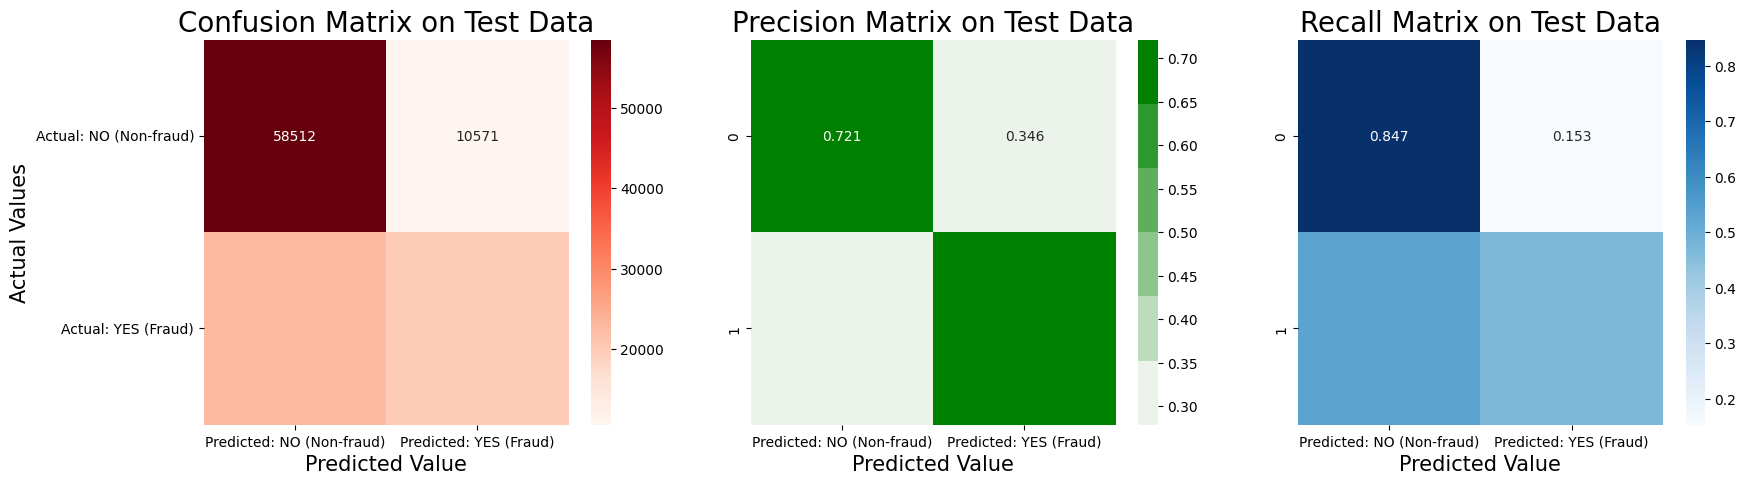

Percentage of misclassified points (Test Data):  29.704504536782423 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.15301883241897427
False Negative Rate (FNR) on Test Data:  0.530827067669173
Balanced Accuracy Score (BACC) on Test Data:  0.6580770499559264
Matthew's Correlation Coefficient (MCC) on Test Data:  0.34445832020356953


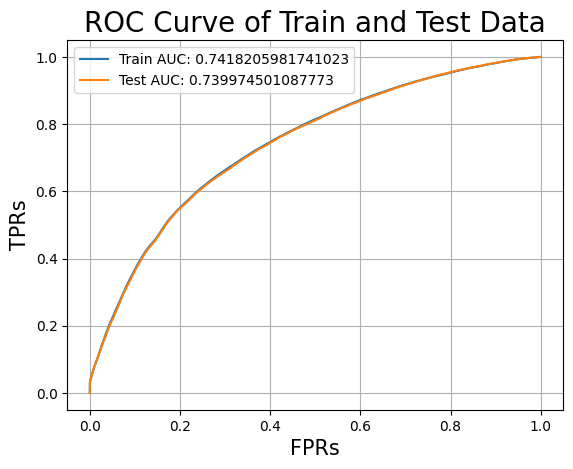

In [58]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR1, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

In [59]:
%%time
# Define an object of LogisticRegression Model
logReg2 = LogisticRegression(class_weight='balanced')

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data
pipelineLR2.fit(xTrain, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=100.0, penalty=l1........................................
[CV 2/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 1/10] START C=100.0, penalty=l1........................................
[CV 1/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 2/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 4/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 5/5; 1/10] START C=100.0, penalty=l1........................................
[CV 4/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 1/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 2/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 5/5; 1/10] END ...........C=100.0, penalty=l

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 3/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.685 total time=  10.1s
[CV 4/5; 7/10] START C=100.0, penalty=l2........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.686 total time=  10.5s
[CV 2/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.683 total time=  10.5s
[CV 4/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.682 total time=  10.3s
[CV 5/5; 7/10] START C=100.0, penalty=l2........................................
[CV 1/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 2/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.683 total time=  10.7s
[CV 3/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 7/10] END .........C=100.0, penalty=l2;, score=0.685 total time=  11.2s
[CV 4/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 7/10] END .........C=100.0, penalty=l2;, score=0.684 total time=  11.0s
[CV 5/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 7/10] END .........C=100.0, penalty=l2;, score=0.683 total time=  11.6s
[CV 1/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 1/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 2/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 2/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 3/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 3/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.3s
[CV 4/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 4/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.3s
[CV 5/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 5/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 1/5; 10/10] START C=0.1, penalty=l1.........................................
[CV 1/5; 10/10] END ........

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 7/10] END .........C=100.0, penalty=l2;, score=0.681 total time=  10.4s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 5/5; 7/10] END .........C=100.0, penalty=l2;, score=0.683 total time=  10.3s
[CV 3/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.683 total time=   9.9s
[CV 2/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.682 total time=  10.3s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.684 total time=  10.4s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 4/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.681 total time=   8.7s
[CV 5/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.681 total time=   8.3s
CPU times: user 13.2 s, sys: 1.66 s, total: 14.9 s
Wall time: 38.9 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=5,
                                    estimator=LogisticRegression(class_weight='balanced'),
                                    n_jobs=-1,
                                    param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                         'penalty': ['l1', 'l2',
                                                                     'elasticnet']},
                                    random_state=1, verbose=10))])

In [60]:
print('Best Parameters found:', pipelineLR2.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 1.0}


## <font color="blue">Training the Model with best hyperparameters on One Hot Encoded Data with balanced Class Weights</font>

In [61]:
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR2 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=1, penalty='l2', class_weight='balanced'))
])

In [62]:
%%time
# Fit the Pipeline on the Train Data
pipelineLR2.fit(xTrain, yTrain)

CPU times: user 13.4 s, sys: 1.96 s, total: 15.3 s
Wall time: 16.1 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression',
                 LogisticRegression(C=1, class_weight='balanced'))])

## <font color="blue">Evaluate the Model now on One Hot Encoded Test Data with balanced Class weights</font>

Log-loss of the Model on  Train  Dataset:  0.5979433896509029
Log-loss of the Model on  Test  Dataset:  0.5996115235344532
F1-Score of the Model on Test Data:  0.6182524521903372


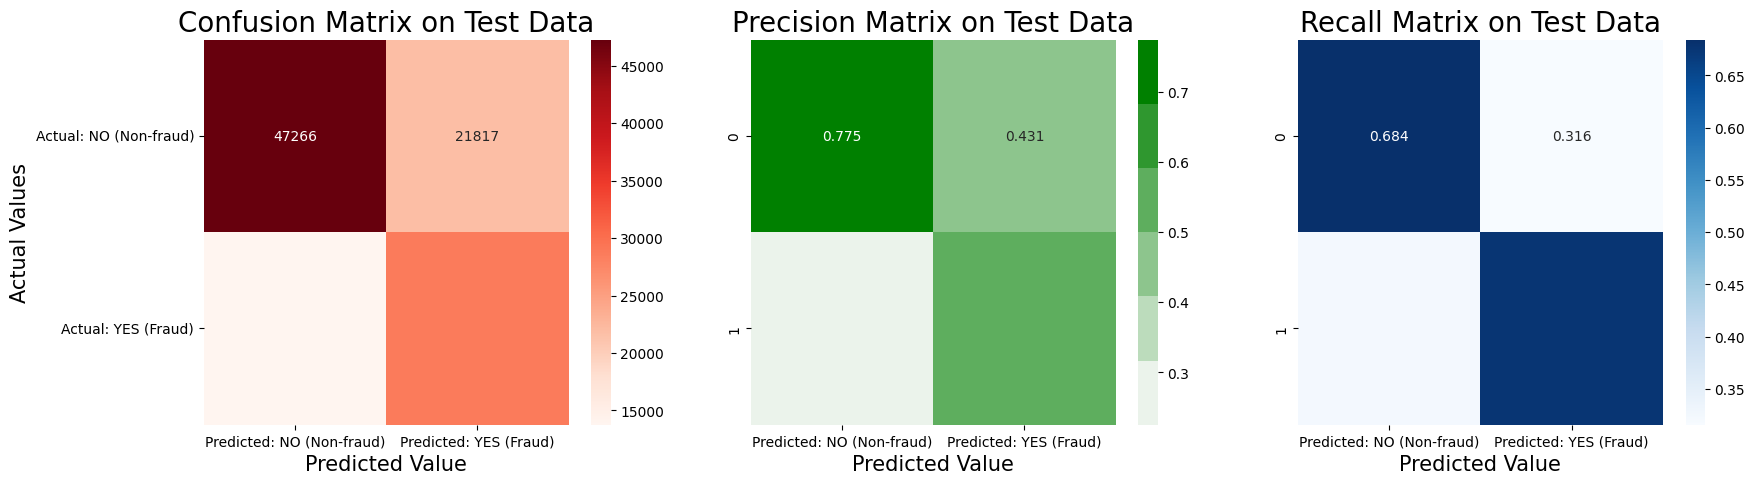

Percentage of misclassified points (Test Data):  31.862275288195406 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.31580852018586336
False Negative Rate (FNR) on Test Data:  0.32319078947368424
Balanced Accuracy Score (BACC) on Test Data:  0.6805003451702263
Matthew's Correlation Coefficient (MCC) on Test Data:  0.35219657360058426


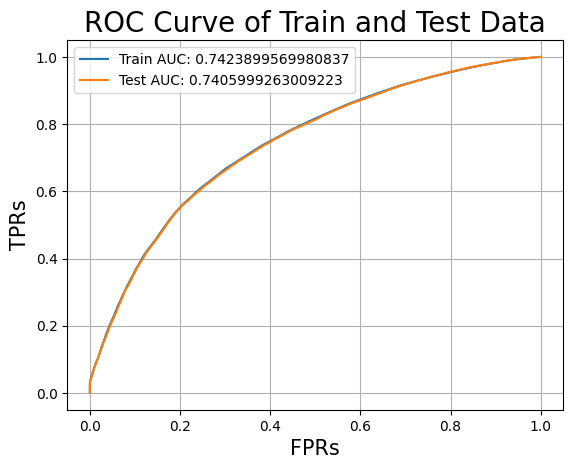

In [63]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR2, xTestData=xTest, yTestData=yTest, xTrainData=xTrain, yTrainData=yTrain)

## <font color="blue">Hyperparameter Tuning on One Hot Encoded Data with Random Undersampling</font>

In [64]:
%%time
# Define an object of LogisticRegression Model
logReg3 = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data having random undersampling
pipelineLR3.fit(xTrainRndmUS, yTrainRndmUS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=100.0, penalty=l1........................................
[CV 2/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 1/10] START C=100.0, penalty=l1........................................
[CV 1/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.1s
[CV 2/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.1s
[CV 3/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.1s
[CV 4/5; 1/10] START C=100.0, penalty=l1........................................
[CV 5/5; 1/10] START C=100.0, penalty=l1........................................
[CV 4/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.1s
[CV 1/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 2/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 5/5; 1/10] END ...........C=100.0, penalty=l

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 2/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.684 total time=   6.3s
[CV 1/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.678 total time=   6.4s
[CV 4/5; 7/10] START C=100.0, penalty=l2........................................
[CV 5/5; 7/10] START C=100.0, penalty=l2........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 3/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.684 total time=   6.7s
[CV 5/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.682 total time=   6.6s
[CV 1/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 2/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.683 total time=   6.9s
[CV 3/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 7/10] END .........C=100.0, penalty=l2;, score=0.678 total time=   8.4s
[CV 4/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 3/5; 7/10] END .........C=100.0, penalty=l2;, score=0.684 total time=   8.6s
[CV 2/5; 7/10] END .........C=100.0, penalty=l2;, score=0.683 total time=   8.7s
[CV 5/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 1/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 1/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.2s
[CV 2/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 2/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.2s
[CV 3/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 3/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.3s
[CV 4/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 4/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.2s
[CV 5/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 5/5; 9/10] END ...C=0.00

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 5/5; 7/10] END .........C=100.0, penalty=l2;, score=0.681 total time=   8.7s
[CV 4/5; 7/10] END .........C=100.0, penalty=l2;, score=0.683 total time=   8.8s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.677 total time=   8.8s
[CV 2/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.682 total time=   8.8s
[CV 3/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.681 total time=   8.5s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.681 total time=   6.6s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.679 total time=   6.4s
CPU times: user 10.6 s, sys: 1.53 s, total: 12.1 s
Wall time: 30.5 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('randomizedSearchCV',
                 RandomizedSearchCV(cv=5,
                                    estimator=LogisticRegression(class_weight='balanced'),
                                    n_jobs=-1,
                                    param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                         'penalty': ['l1', 'l2',
                                                                     'elasticnet']},
                                    random_state=1, verbose=10))])

In [65]:
print('Best Parameters found:', pipelineLR3.steps[2][1].best_params_)

Best Parameters found: {'penalty': 'l2', 'C': 1.0}


## <font color="blue">Train the Model now with best hyperparameters on One Hot Encoded Data with Random Undersampling</font>

In [66]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR3 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=100, penalty='l2'))
])

# Fit the Pipeline on the Train Data with random undersampling
pipelineLR3.fit(xTrainRndmUS, yTrainRndmUS)

CPU times: user 9.8 s, sys: 1.1 s, total: 10.9 s
Wall time: 11 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression', LogisticRegression(C=100))])

## <font color="blue">Evaluate the Model now on One Hot Encoded Test Data with Random Undersampling</font>

Log-loss of the Model on  Train  Dataset:  0.5984056336843996
Log-loss of the Model on  Test  Dataset:  0.5995148970833198
F1-Score of the Model on Test Data:  0.6182820493570287


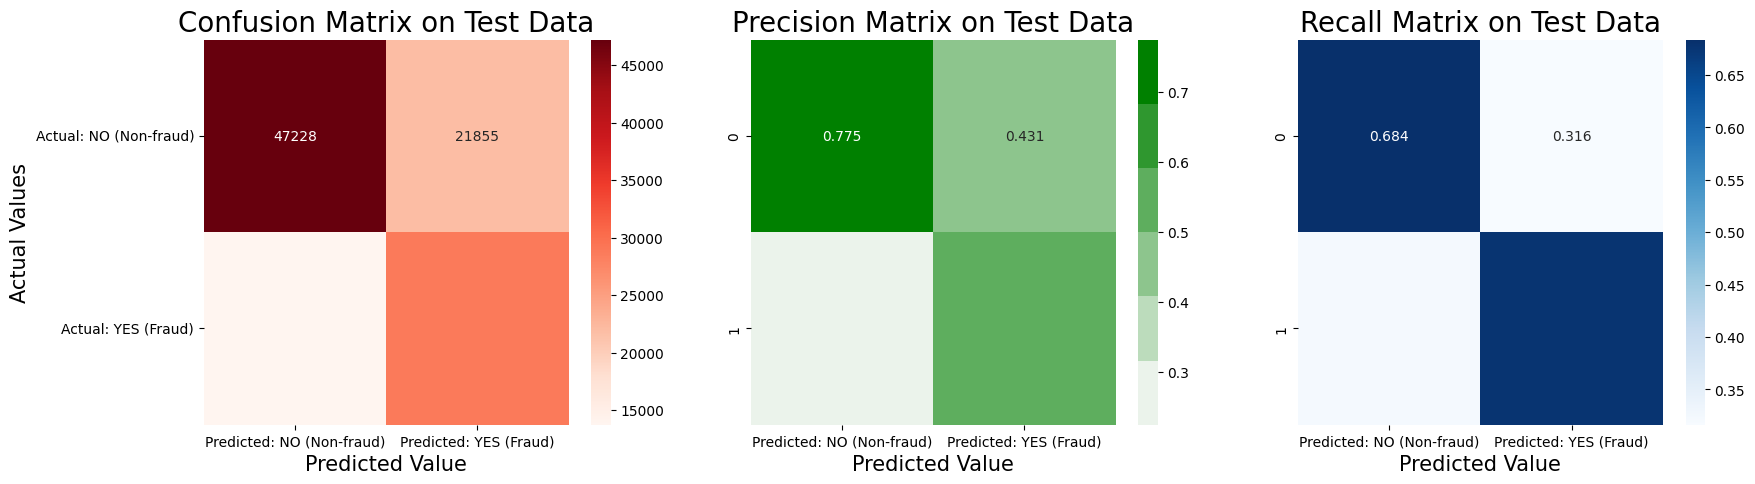

Percentage of misclassified points (Test Data):  31.879293820481358 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.3163585831535978
False Negative Rate (FNR) on Test Data:  0.3227443609022556
Balanced Accuracy Score (BACC) on Test Data:  0.6804485279720732
Matthew's Correlation Coefficient (MCC) on Test Data:  0.3520618751757289


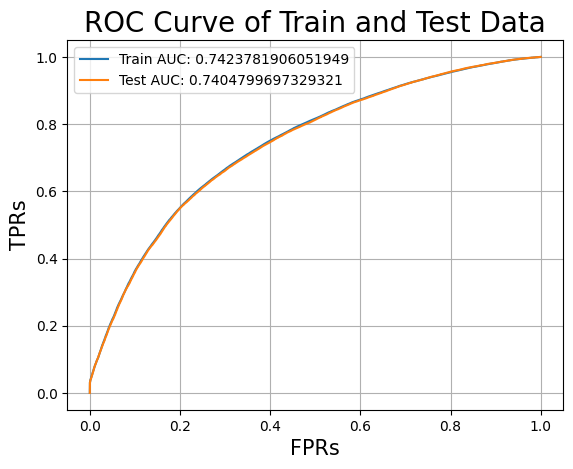

In [67]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR3, xTestData=xTest, yTestData=yTest, xTrainData=xTrainRndmUS, yTrainData=yTrainRndmUS)

## <font color="blue">Hyperparameter Tuning on One Hot Encoded Data with SMOTE Oversampling</font>

In [68]:
%%time
# Define an object of LogisticRegression Model
logReg4 = LogisticRegression()

# Define different values for the Hyperparameters to do tuning
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. RandomizedSearchCV using Logistic Regression
pipelineLR4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('randomizedSearchCV', RandomizedSearchCV(logReg2, param_distributions=params, n_iter=10, cv=5, verbose=10, n_jobs=-1, random_state=1))
])

# Fit the Pipeline on the Train Data having SMOTE Oversampling
pipelineLR4.fit(xTrainSMOTE, yTrainSMOTE)

print('Best Parameters found:', pipelineLR4.steps[2][1].best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=100.0, penalty=l1........................................
[CV 2/5; 1/10] START C=100.0, penalty=l1........................................
[CV 3/5; 1/10] START C=100.0, penalty=l1........................................
[CV 1/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 2/5; 1/10] END ...........C=100.0, penalty=l1;, score=nan total time=   0.2s
[CV 4/5; 1/10] START C=100.0, penalty=l1........................................
[CV 1/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 5/5; 1/10] START C=100.0, penalty=l1........................................
[CV 2/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 3/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 5/5; 2/10] START C=1.0, penalty=l2..........................................
[CV 4/5; 2/10] START C=1.0, penalty=l2..........

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 5/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.797 total time=  12.7s
[CV 4/5; 7/10] START C=100.0, penalty=l2........................................
[CV 3/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.645 total time=  12.8s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 5/5; 7/10] START C=100.0, penalty=l2........................................
[CV 4/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.786 total time=  12.9s
[CV 1/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.647 total time=  13.1s
[CV 1/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 2/5; 2/10] END ...........C=1.0, penalty=l2;, score=0.644 total time=  13.1s
[CV 2/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 3/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 7/10] END .........C=100.0, penalty=l2;, score=0.647 total time=  12.5s
[CV 4/5; 8/10] START C=0.01, penalty=l2.........................................


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 3/5; 7/10] END .........C=100.0, penalty=l2;, score=0.646 total time=  12.7s
[CV 2/5; 7/10] END .........C=100.0, penalty=l2;, score=0.645 total time=  12.9s
[CV 1/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 5/5; 8/10] START C=0.01, penalty=l2.........................................
[CV 1/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 2/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 2/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 3/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 3/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 4/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 4/5; 9/10] END ...C=0.001, penalty=elasticnet;, score=nan total time=   0.4s
[CV 5/5; 9/10] START C=0.001, penalty=elasticnet................................
[CV 5/5; 9/10] END ...C=0.00

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 1/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.643 total time=  11.4s
[CV 2/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.641 total time=  11.5s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV 4/5; 7/10] END .........C=100.0, penalty=l2;, score=0.789 total time=  11.9s
[CV 5/5; 7/10] END .........C=100.0, penalty=l2;, score=0.796 total time=  11.8s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.640 total time=  11.9s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.786 total time=  10.4s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 8/10] END ..........C=0.01, penalty=l2;, score=0.791 total time=  10.5s
Best Parameters found: {'penalty': 'l2', 'C': 100.0}
CPU times: user 16.7 s, sys: 3.21 s, total: 19.9 s
Wall time: 47.8 s


## <font color="blue">Training the Model with best hyperparameters on One Hot Encoded Data with SMOTE Oversampling</font>

In [69]:
%%time
# Create Pipeline: 
# 1. Standardization of numerical features.
# 2. One-hot Encoding of 'State' and 'Country' features.
# 3. Logistic Regression with best hyperparameters
pipelineLR4 = sklearnPipeline(steps=[
    ('standardization', Standardize(numericalFeatures=featuresToStd)),
    ('OneHotEncoder', OneHotEncoder(categoricalFeatures=['State', 'Country'])),
    ('logisticRegression', LogisticRegression(C=1, penalty='l2'))
])

# Fit the Pipeline on the Train Data with random undersampling
pipelineLR4.fit(xTrainSMOTE, yTrainSMOTE)

CPU times: user 15.9 s, sys: 2.55 s, total: 18.5 s
Wall time: 18.9 s


Pipeline(steps=[('standardization',
                 Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                                'TreatmentDuration', 'Age',
                                                'TotalClaimAmount',
                                                'IPTotalAmount',
                                                'OPTotalAmount',
                                                'UniquePhysCount',
                                                'PhysRoleCount'])),
                ('OneHotEncoder',
                 OneHotEncoder(categoricalFeatures=['State', 'Country'])),
                ('logisticRegression', LogisticRegression(C=1))])

## <font color="blue">Evaluating the Model on One Hot Encoded Test Data with SMOTE Oversampling</font>

Log-loss of the Model on  Train  Dataset:  0.5417175820194742
Log-loss of the Model on  Test  Dataset:  0.6054181347819906
F1-Score of the Model on Test Data:  0.5648073034592147


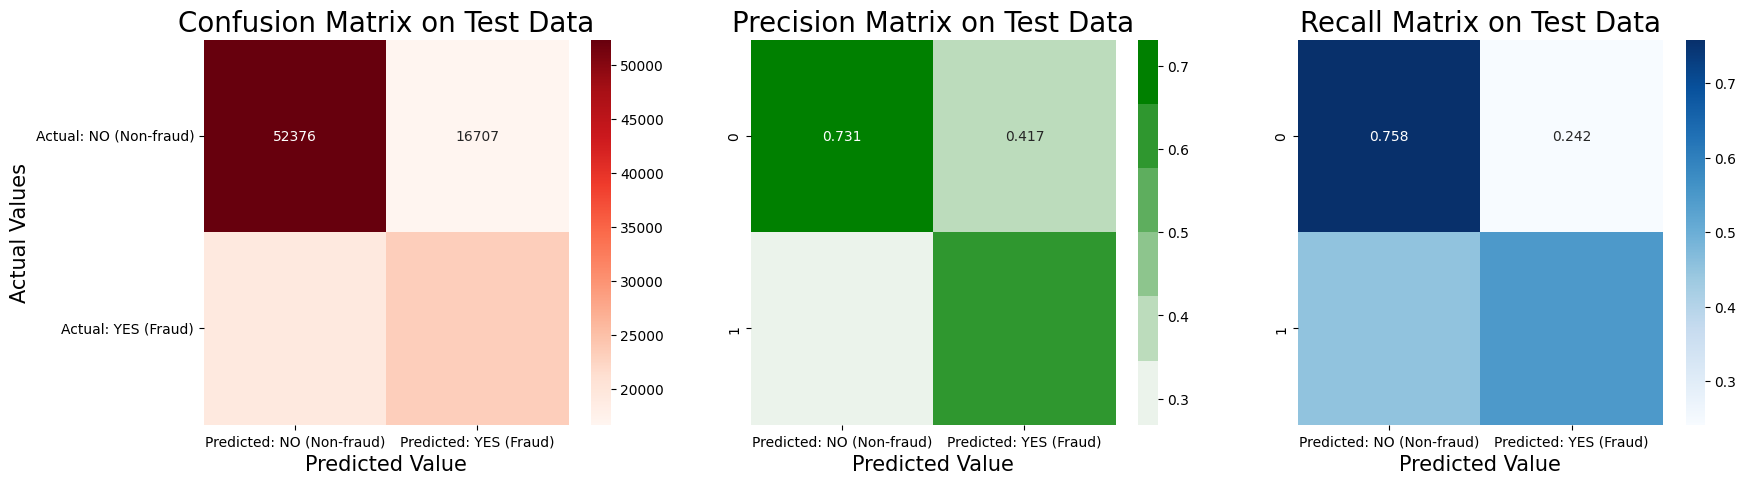

Percentage of misclassified points (Test Data):  32.19458452388417 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR) on Test Data:  0.2418395263668341
False Negative Rate (FNR) on Test Data:  0.4519736842105263
Balanced Accuracy Score (BACC) on Test Data:  0.6530933947113198
Matthew's Correlation Coefficient (MCC) on Test Data:  0.3100856952246826


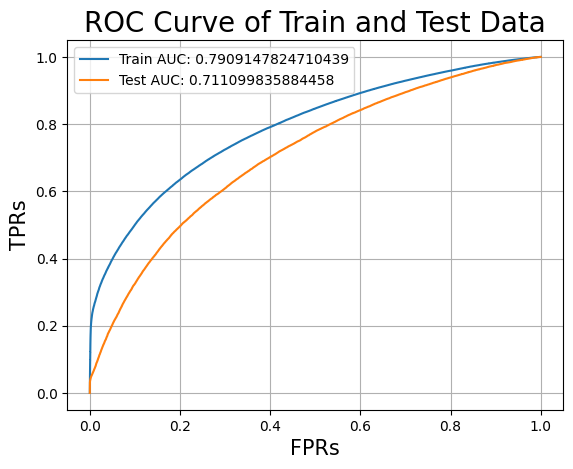

In [70]:
# Transformation of the Test Data (similar to the Train Data used while training the model) is taken care by the pipeline internally.
showPerformanceMetrics(model=pipelineLR4, xTestData=xTest, yTestData=yTest, xTrainData=xTrainSMOTE, yTrainData=yTrainSMOTE)